### Scenario- You are a junior data scientist on the Zillow data science team and are tasked with the following:

- Predict the property tax assessed values ('taxvaluedollarcnt') of Single Family Properties that had a transaction during 2017
- Make recommendations to improve the current model
- Find the states and counties in which these properties are located


### Business goals:

- Create an ML Regression model that will predict property values ('taxvaluedollarcnt') of Single Family Properties using attributes of the properties
- Find the key drivers of property value for Single Family Properties. 
- Deliver a report that the data science team can read through and replicate. The team must be able to understand what steps were taken and why, and what the outcome was.
- Make recommendations on what works and what doesn't in predicting these property values.

In [2]:
#Usual imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#my modules
import wrangle as wr
import evaluate as ev
import explore as exp
from env import get_db_url
from acquire import get_prop_vals

#sklearn imports
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.feature_selection import f_regression, SelectKBest, RFE
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor

#extras
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 250)

ImportError: cannot import name 'get_telco_data' from 'acquire' (/Users/tarrence_home/codeup-data-science/regression-project/acquire.py)

### Acquiring data

In [2]:
# Show list of DBs in Codeup SQL server
wr.show_codeup_dbs()


List of Codeup DBs:



,Database
0,albums_db
1,chipotle
2,curriculum_logs
3,elo_db
4,employees
5,fruits_db
6,grocery_db
7,home_credit
8,information_schema
9,innis_1673


In [3]:
# Show tables in zillow DB
url = get_db_url('zillow')
pd.read_sql('SHOW TABLES', url)

,Tables_in_zillow
0,airconditioningtype
1,architecturalstyletype
2,buildingclasstype
3,heatingorsystemtype
4,predictions_2016
5,predictions_2017
6,properties_2016
7,properties_2017
8,propertylandusetype
9,storytype


In [4]:
#Show columns and data types in predictions_2017 table
pd.read_sql('DESCRIBE predictions_2017', url)

,Field,Type,Null,Key,Default,Extra
0,id,bigint,YES,MUL,None,
1,parcelid,bigint,YES,,None,
2,logerror,double,YES,,None,
3,transactiondate,text,YES,,None,


In [5]:
#Show columns and data types in propertylandusetype table
pd.read_sql('DESCRIBE propertylandusetype', url)

,Field,Type,Null,Key,Default,Extra
0,propertylandusetypeid,bigint,NO,PRI,None,
1,propertylandusedesc,text,YES,,None,


In [6]:
#Show columns and data types in properties_2017 table
pd.read_sql('DESCRIBE properties_2017', url)

,Field,Type,Null,Key,Default,Extra
0,id,bigint,YES,MUL,None,
1,parcelid,bigint,YES,MUL,None,
2,airconditioningtypeid,double,YES,,None,
3,architecturalstyletypeid,double,YES,,None,
4,basementsqft,double,YES,,None,
5,bathroomcnt,double,YES,,None,
6,bedroomcnt,double,YES,,None,
7,buildingclasstypeid,double,YES,,None,
8,buildingqualitytypeid,double,YES,,None,
9,calculatedbathnbr,double,YES,,None,


In [3]:
# Acquire data using SQL query from acquire module
prop_vals = get_prop_vals()
prop_vals.info()
prop_vals.head()

Reading from CSV file...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56071 entries, 0 to 56070
Data columns (total 66 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    56071 non-null  int64  
 1   id                            56071 non-null  int64  
 2   parcelid                      56071 non-null  int64  
 3   airconditioningtypeid         13650 non-null  float64
 4   architecturalstyletypeid      61 non-null     float64
 5   basementsqft                  43 non-null     float64
 6   bathroomcnt                   56071 non-null  float64
 7   bedroomcnt                    56071 non-null  float64
 8   buildingclasstypeid           0 non-null      float64
 9   buildingqualitytypeid         36989 non-null  float64
 10  calculatedbathnbr             55691 non-null  float64
 11  decktypeid                    360 non-null    float64
 12  finishedfloor1squarefeet      4756 

,Unnamed: 0,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id.1,parcelid.1,logerror,transactiondate,propertylandusetypeid.1,propertylandusedesc
0,0,1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34140430.0,-118625364.0,4083.0,NaN,NaN,NaN,NaN,NaN,0109,261.0,LCA11*,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN,1,17052889,0.055619,2017-01-01,261,Single Family Residential
1,1,15,11193347,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34585014.0,-118162010.0,11975.0,NaN,NaN,NaN,NaN,NaN,0100,261.0,PDA1*,6.037910e+07,40227.0,3101.0,NaN,97329.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,2016.0,10.0,NaN,NaN,NaN,NaN,15,17110996,0.008669,2017-01-02,261,Single Family Residential
2,2,16,11215747,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34563376.0,-118019104.0,9403.0,NaN,NaN,NaN,NaN,NaN,0100,261.0,PDA21*,6.037911e+07,40227.0,3101.0,NaN,97330.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,2016.0,10.0,NaN,NaN,NaN,NaN,16,14375300,-0.021896,2017-01-02,261,Single Family Residential
3,3,17,11229347,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34526913.0,-118050581.0,3817.0,NaN,NaN,NaN,NaN,NaN,0100,261.0,LCA21*,6.037911e+07,40227.0,3101.0,NaN,97330.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2108.0,2016.0,2108.0,174.21,NaN,NaN,NaN,17,12045625,-0.017167,2017-01-02,261,Single Family Residential
4,4,20,11324547,1.0,NaN,NaN,2.0,4.0,NaN,8.0,2.0,NaN,NaN,3633.0,3633.0,NaN,NaN,NaN,NaN,6037.0,NaN,2.0,NaN,NaN,NaN,2.0,34560018.0,-118169806.0,9826.0,NaN,NaN,NaN,NaN,NaN,0100,261.0,LCA22,6.037910e+07,40227.0,3101.0,NaN,97329.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,2005.0,NaN,NaN,222321.0,296425.0,2016.0,74104.0,6941.39,NaN,NaN,NaN,20,12325145,0.042463,2017-01-02,261,Single Family Residential


In [5]:
# Getting null/NaN count
print(prop_vals.isna().sum())
print('-----------------')
print(prop_vals.isnull().sum())

id                                  0
parcelid                            0
airconditioningtypeid           42421
architecturalstyletypeid        56010
basementsqft                    56028
bathroomcnt                         0
bedroomcnt                          0
buildingclasstypeid             56071
buildingqualitytypeid           19082
calculatedbathnbr                 380
decktypeid                      55711
finishedfloor1squarefeet        51315
calculatedfinishedsquarefeet      225
finishedsquarefeet12              415
finishedsquarefeet13            56071
finishedsquarefeet15            56071
finishedsquarefeet50            51315
finishedsquarefeet6             55881
fips                                0
fireplacecnt                    48441
fullbathcnt                       380
garagecarcnt                    37825
garagetotalsqft                 37825
hashottuborspa                  54831
heatingorsystemtypeid           18996
latitude                            0
longitude   

### Cleaning

In [5]:
prop_vals = prop_vals[prop_vals.notna() == True]


prop_vals.info()
prop_vals.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56071 entries, 0 to 56070
Data columns (total 66 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    56071 non-null  int64  
 1   id                            56071 non-null  int64  
 2   parcelid                      56071 non-null  int64  
 3   airconditioningtypeid         13650 non-null  float64
 4   architecturalstyletypeid      61 non-null     float64
 5   basementsqft                  43 non-null     float64
 6   bathroomcnt                   56071 non-null  float64
 7   bedroomcnt                    56071 non-null  float64
 8   buildingclasstypeid           0 non-null      float64
 9   buildingqualitytypeid         36989 non-null  float64
 10  calculatedbathnbr             55691 non-null  float64
 11  decktypeid                    360 non-null    float64
 12  finishedfloor1squarefeet      4756 non-null   float64
 13  c

,Unnamed: 0,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id.1,parcelid.1,logerror,transactiondate,propertylandusetypeid.1,propertylandusedesc
0,0,1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34140430.0,-118625364.0,4083.0,NaN,NaN,NaN,NaN,NaN,0109,261.0,LCA11*,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN,1,17052889,0.055619,2017-01-01,261,Single Family Residential
1,1,15,11193347,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34585014.0,-118162010.0,11975.0,NaN,NaN,NaN,NaN,NaN,0100,261.0,PDA1*,6.037910e+07,40227.0,3101.0,NaN,97329.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,2016.0,10.0,NaN,NaN,NaN,NaN,15,17110996,0.008669,2017-01-02,261,Single Family Residential
2,2,16,11215747,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34563376.0,-118019104.0,9403.0,NaN,NaN,NaN,NaN,NaN,0100,261.0,PDA21*,6.037911e+07,40227.0,3101.0,NaN,97330.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,2016.0,10.0,NaN,NaN,NaN,NaN,16,14375300,-0.021896,2017-01-02,261,Single Family Residential
3,3,17,11229347,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34526913.0,-118050581.0,3817.0,NaN,NaN,NaN,NaN,NaN,0100,261.0,LCA21*,6.037911e+07,40227.0,3101.0,NaN,97330.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2108.0,2016.0,2108.0,174.21,NaN,NaN,NaN,17,12045625,-0.017167,2017-01-02,261,Single Family Residential
4,4,20,11324547,1.0,NaN,NaN,2.0,4.0,NaN,8.0,2.0,NaN,NaN,3633.0,3633.0,NaN,NaN,NaN,NaN,6037.0,NaN,2.0,NaN,NaN,NaN,2.0,34560018.0,-118169806.0,9826.0,NaN,NaN,NaN,NaN,NaN,0100,261.0,LCA22,6.037910e+07,40227.0,3101.0,NaN,97329.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,2005.0,NaN,NaN,222321.0,296425.0,2016.0,74104.0,6941.39,NaN,NaN,NaN,20,12325145,0.042463,2017-01-02,261,Single Family Residential


In [6]:
prop_vals.describe()

,Unnamed: 0,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock,id.1,parcelid.1,logerror,propertylandusetypeid.1
count,56071.000000,56071.000000,5.607100e+04,13650.000000,61.000000,43.000000,56071.000000,56071.000000,0.0,36989.000000,55691.000000,360.0,4756.000000,55846.000000,55656.000000,0.0,0.0,4756.000000,190.000000,56071.000000,7630.000000,55691.000000,18246.000000,18246.000000,1240.0,37075.000000,5.607100e+04,5.607100e+04,5.572300e+04,10951.0,773.000000,412.0,828.0,10111.0,56071.0,5.607100e+04,55017.000000,56071.000000,20778.000000,55972.000000,56071.000000,43.0,6012.000000,69.0,37079.000000,2104.000000,63.000000,55828.000000,15492.000000,68.0,5.587500e+04,5.607100e+04,56071.000000,5.607100e+04,5.594700e+04,1129.000000,5.568400e+04,56071.000000,5.607100e+04,56071.000000,56071.0
mean,28035.000000,38682.430044,1.312307e+07,2.361685,7.409836,591.255814,2.239723,3.289490,NaN,6.165860,2.253982,66.0,1491.192178,1868.308617,1870.150873,NaN,NaN,1505.498949,1328.663158,6048.837991,1.180472,2.199314,1.922997,488.092075,1.0,4.079541,3.401647e+07,-1.182069e+08,1.155184e+04,1.0,522.407503,1.0,1.0,1.0,261.0,6.049143e+07,35476.525674,2559.404166,180789.462990,96599.105267,1.880295,7.0,1.012808,6.0,1.000971,338.788498,253.111111,1961.186466,1.384715,1.0,1.799424e+05,4.576434e+05,2015.998645,2.783301e+05,5.589562e+03,13.925598,6.049105e+13,38682.430044,1.299562e+07,0.016887,261.0
std,16186.447809,22361.083553,5.598158e+06,3.736537,2.610090,471.661960,1.006803,0.958204,NaN,1.696977,0.993463,0.0,630.691353,966.979521,966.875756,NaN,NaN,685.321170,839.838932,21.232399,0.489032,0.973538,0.574359,162.189431,0.0,2.547051,2.490033e+05,3.527609e+05,9.135534e+04,0.0,162.067482,0.0,0.0,0.0,0.0,2.108079e+05,54078.397847,787.688535,162232.131494,4456.588212,3.150662,0.0,0.134050,0.0,0.038150,257.490890,271.928484,21.994730,0.532653,0.0,3.667285e+05,6.635581e+05,0.045855,4.205952e+05,8.541899e+03,1.552780,2.104864e+11,22361.083553,3.233796e+06,0.172747,0.0
min,0.000000,1.000000,1.071174e+07,1.000000,2.000000,63.000000,0.000000,0.000000,NaN,1.000000,1.000000,66.0,272.000000,20.000000,20.000000,NaN,NaN,272.000000,368.000000,6037.000000,1.000000,1.000000,0.000000,0.000000,1.0,1.000000,3.334071e+07,-1.194484e+08,1.670000e+02,1.0,28.000000,1.0,1.0,1.0,261.0,6.037101e+07,3491.000000,1286.000000,6952.000000,95982.000000,0.000000,7.0,1.000000,6.0,1.000000,11.000000,14.000000,1862.000000,1.000000,1.0,5.000000e+00,9.000000e+00,2014.000000,4.000000e+00,8.300000e+00,6.000000,6.037101e+13,1.000000,1.071186e+07,-4.655420,261.0
25%,14017.500000,19467.000000,1.155808e+07,1.000000,7.000000,218.000000,2.000000,3.000000,NaN,4.000000,2.000000,66.0,1133.000000,1260.000000,1262.000000,NaN,NaN,1138.000000,809.750000,6037.000000,1.000000,2.000000,2.000000,420.000000,1.0,2.000000,3.383687e+07,-1.184038e+08,5.687000e+03,1.0,435.000000,1.0,1.0,1.0,261.0,6.037400e+07,12447.000000,2061.000000,41131.000000,96193.000000,0.000000,7.0,1.000000,6.0,1.000000,200.000000,98.000000,1949.000000,1.000000,1.0,7.512250e+04,1.870260e+05,2016.000000,7.789400e+04,2.524055e+03,14.000000,6.037400e+13,19467.000000,1.153868e+07,-0.024377,261.0
50%,28035.000000,38802.

In [9]:
prop_vals_ex = prop_vals[['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'yearbuilt', 'taxamount', 'fips']]

prop_vals_ex.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56071 entries, 0 to 56070
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    56071 non-null  float64
 1   bathroomcnt                   56071 non-null  float64
 2   calculatedfinishedsquarefeet  55846 non-null  float64
 3   taxvaluedollarcnt             56071 non-null  float64
 4   yearbuilt                     55828 non-null  float64
 5   taxamount                     55947 non-null  float64
 6   fips                          56071 non-null  float64
dtypes: float64(7)
memory usage: 3.0 MB


In [11]:
prop_vals_ex = prop_vals_ex.dropna()
prop_vals_ex.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55735 entries, 4 to 56070
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    55735 non-null  float64
 1   bathroomcnt                   55735 non-null  float64
 2   calculatedfinishedsquarefeet  55735 non-null  float64
 3   taxvaluedollarcnt             55735 non-null  float64
 4   yearbuilt                     55735 non-null  float64
 5   taxamount                     55735 non-null  float64
 6   fips                          55735 non-null  float64
dtypes: float64(7)
memory usage: 3.4 MB


In [14]:
prop_vals_ex = prop_vals_ex.rename(columns= {'bedroomcnt': 'beds', 
'bathroomcnt': 'baths', 
'calculatedfinishedsquarefeet': 'calc_sqft', 
'taxvaluedollarcnt': 'tax_val', 
'yearbuilt': 'yr_built', 
'taxamount': 'tax_amt', 
'fips': 'fips'})

prop_vals_ex.info()
prop_vals_ex.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55735 entries, 4 to 56070
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   beds       55735 non-null  float64
 1   baths      55735 non-null  float64
 2   calc_sqft  55735 non-null  float64
 3   tax_val    55735 non-null  float64
 4   yr_built   55735 non-null  float64
 5   tax_amt    55735 non-null  float64
 6   fips       55735 non-null  float64
dtypes: float64(7)
memory usage: 3.4 MB


,beds,baths,calc_sqft,tax_val,yr_built,tax_amt,fips
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0
6,3.0,4.0,1620.0,847770.0,2011.0,10244.94,6037.0
7,3.0,2.0,2077.0,646760.0,1926.0,7924.68,6037.0
11,0.0,0.0,1200.0,5328.0,1972.0,91.60,6037.0
14,0.0,0.0,171.0,6920.0,1973.0,255.17,6037.0


In [15]:
prop_vals_ex.describe()

,beds,baths,calc_sqft,tax_val,yr_built,tax_amt,fips
count,55735.000000,55735.000000,55735.000000,5.573500e+04,55735.000000,55735.000000,55735.000000
mean,3.304136,2.249430,1868.655710,4.562745e+05,1961.208056,5558.867400,6048.773787
std,0.935897,0.997839,966.601756,5.934410e+05,21.981195,6821.650187,21.149903
min,0.000000,0.000000,20.000000,1.050000e+02,1862.000000,13.490000,6037.000000
25%,3.000000,2.000000,1261.000000,1.882510e+05,1949.000000,2531.460000,6037.000000
50%,3.000000,2.000000,1630.000000,3.302120e+05,1958.000000,4132.100000,6037.000000
75%,4.000000,3.000000,2216.000000,5.342580e+05,1976.000000,6409.710000,6059.000000
max,25.000000,20.000000,26345.000000,3.016684e+07,2016.000000,342940.380000,6111.000000


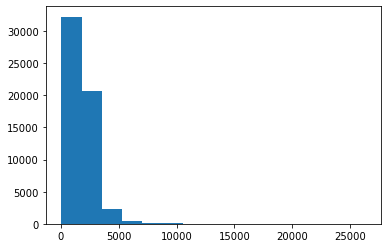

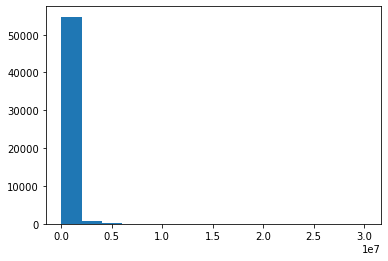

(array([5.4692e+04, 8.1400e+02, 1.4700e+02, 4.6000e+01, 1.9000e+01,
        5.0000e+00, 6.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.34900000e+01, 2.28752827e+04, 4.57370753e+04, 6.85988680e+04,
        9.14606607e+04, 1.14322453e+05, 1.37184246e+05, 1.60046039e+05,
        1.82907831e+05, 2.05769624e+05, 2.28631417e+05, 2.51493209e+05,
        2.74355002e+05, 2.97216795e+05, 3.20078587e+05, 3.42940380e+05]),
 <BarContainer object of 15 artists>)

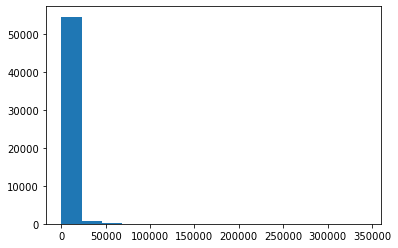

In [23]:
plt.hist(prop_vals_ex.calc_sqft,bins= 15)
plt.show()
plt.hist(prop_vals_ex.tax_val, bins= 15)
plt.show()
plt.hist(prop_vals_ex.tax_amt, bins=15)

In [19]:
round(len(prop_vals_ex) ** 0.5, 0)

236.0

In [21]:
import math

math.sqrt(236)

15.362291495737216

In [24]:
# Get train, validate, and test splits of clean df
pvx_train, pvx_validate, pvx_test = ev.get_splits(prop_vals_ex)

print(pvx_train.shape, pvx_validate.shape, pvx_test.shape)

(31211, 7) (11147, 7) (13377, 7)


In [28]:
X_pvx_tr = pvx_train.drop(columns= ['tax_val'])
y_pvx_tr = pvx_train.tax_val

X_pvx_val = pvx_validate.drop(columns= ['tax_val'])
y_pvx_val = pvx_validate.tax_val

X_pvx_test = pvx_test.drop(columns= ['tax_val'])
y_pvx_test = pvx_test.tax_val


X_pvx_tr.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 31211 entries, 8000 to 20721
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   beds       31211 non-null  float64
 1   baths      31211 non-null  float64
 2   calc_sqft  31211 non-null  float64
 3   yr_built   31211 non-null  float64
 4   tax_amt    31211 non-null  float64
 5   fips       31211 non-null  float64
dtypes: float64(6)
memory usage: 1.7 MB


In [31]:
scaler = MinMaxScaler()
#X_tr_scaled = 

array([[0.12      , 0.1       , 0.0601286 , 0.6038961 , 0.00492469,
        0.2972973 ],
       [0.12      , 0.1       , 0.06557699, 0.66233766, 0.01383054,
        0.        ],
       [0.12      , 0.1       , 0.06223924, 0.61038961, 0.01650341,
        0.2972973 ],
       ...,
       [0.12      , 0.1       , 0.06052128, 0.7012987 , 0.00375456,
        1.        ],
       [0.12      , 0.1       , 0.0849654 , 0.58441558, 0.00589774,
        0.        ],
       [0.12      , 0.125     , 0.14931527, 0.76623377, 0.02185263,
        0.2972973 ]])